## Data Preprocess

In [73]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Read data

In [5]:
df = pd.read_csv('./kaggle/input/rtatman/deceptive-opinion-spam-corpus/deceptive-opinion.csv')
df = df.drop(["hotel", "polarity","source"], axis=1)

# shuffle
df = df.sample(frac=1) 

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 'species'. 
df['deceptive']= label_encoder.fit_transform(df['deceptive']) 
df['deceptive'].unique() 

#dataset description #truthful=1 deceptive=0
df.groupby('deceptive').describe()

text                                                               
          count unique                                                top freq
deceptive                                                                     
0           800    800  The Ambassador East is a particularly crappy p...    1
1           800    796  Very disappointed in our stay in Chicago Monoc...    2

### Clean data

In [92]:
def clean_data(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

df['text'] = df['text'].apply(clean_data)

/var/folders/b1/jch_lq455tj555ym4z65fvk00000gn/T/ipykernel_37004/3103000664.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


### Data Split

In [93]:
X = df.text
y = df.deceptive
X = X.map(lambda a: clean_data(a))

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 1600
Number of rows in the training set: 1200
Number of rows in the test set: 400


## Model Training

### Logistic Regression - Baseline

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [95]:
count_vector = CountVectorizer()

training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

lr = LogisticRegression()
lr.fit(training_data, y_train)
lrpredicted = lr.predict(testing_data)

/Users/sylviaz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Attention-based bidirectional LSTM

In [96]:
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [102]:
X = df.text
y = df.deceptive
# X = X.map(lambda a: clean_data(a))

# Tokenization
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer.fit_on_texts(X)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(X)

vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

# Pad
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)
processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)

# Embedding
embeddings_index = {}
f = open(os.path.join('./kaggle/input/rtatman/glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

Vocab size: 9635
Longest comment size: 795
Average comment size: 150.44875
Stdev of comment size: 88.50470254985042
Max comment size: 415
x_train shape: (1200, 415)
x_test shape: (400, 415)
Found 400000 word vectors.


In [103]:
from keras.layers import Bidirectional, Embedding, Input, LSTM, Dense, Dropout, concatenate, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializers, regularizers, constraints
import keras

In [104]:
class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
def get_model():
    review_input = Input(shape=(max_len,), dtype='int32')
    review_input_post = Input(shape=(max_len,), dtype='int32')

    x1 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
    x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Attention(max_len)(x1)

    x2 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
    x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Attention(max_len)(x2)

    x = concatenate([x1, x2])
    x = Dense(50, activation='relu')(x)
    x= Dropout(0.2)(x)
    x = BatchNormalization()(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[review_input, review_input_post], outputs=preds)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

### Experiment

#### Epoch = 15, Batch Size = 32

In [105]:
model = get_model()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 embedding_22 (Embedding)    (None, 415, 100)             963600    ['input_25[0][0]']            
                                                                                                  
 embedding_23 (Embedding)    (None, 415, 100)             963600    ['input_26[0][0]']            
                                                                                            

In [106]:
early_stopping_monitor = EarlyStopping(patience=10)

history = model.fit([processed_x_train, processed_pre_x_train], 
                    y_train, 
                    validation_data=([processed_x_test, processed_pre_x_test], y_test), 
                    epochs=15, batch_size=32, callbacks=[early_stopping_monitor], verbose=1)

loss, accuracy, F1_score, precision, recall = model.evaluate([processed_x_test, processed_pre_x_test], y_test)

Epoch 1/15
38/38 [==============================] - 31s 607ms/step - loss: 0.6974 - accuracy: 0.5900 - f1_m: 0.5837 - precision_m: 0.5972 - recall_m: 0.5940 - val_loss: 0.6799 - val_accuracy: 0.5675 - val_f1_m: 0.3223 - val_precision_m: 0.7615 - val_recall_m: 0.2092
Epoch 2/15
38/38 [==============================] - 34s 901ms/step - loss: 0.5887 - accuracy: 0.7042 - f1_m: 0.7014 - precision_m: 0.7095 - recall_m: 0.7069 - val_loss: 0.6558 - val_accuracy: 0.5850 - val_f1_m: 0.6992 - val_precision_m: 0.5419 - val_recall_m: 0.9949
Epoch 3/15
38/38 [==============================] - 30s 777ms/step - loss: 0.4767 - accuracy: 0.7717 - f1_m: 0.7691 - precision_m: 0.7768 - recall_m: 0.7799 - val_loss: 0.5753 - val_accuracy: 0.7250 - val_f1_m: 0.6350 - val_precision_m: 0.9417 - val_recall_m: 0.4806
Epoch 4/15
38/38 [==============================] - 39s 1s/step - loss: 0.3698 - accuracy: 0.8367 - f1_m: 0.8395 - precision_m: 0.8183 - recall_m: 0.8732 - val_loss: 0.4888 - val_accuracy: 0.8000 - v

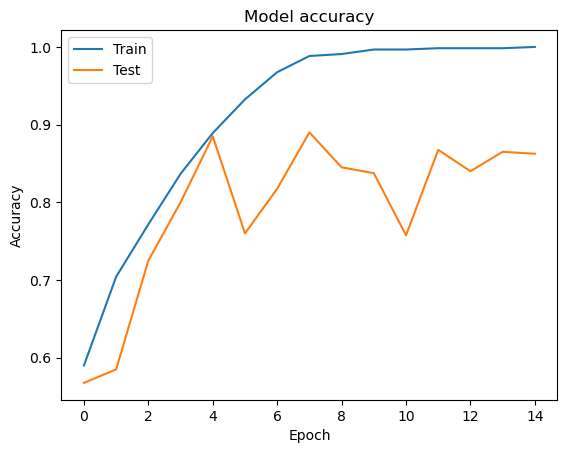

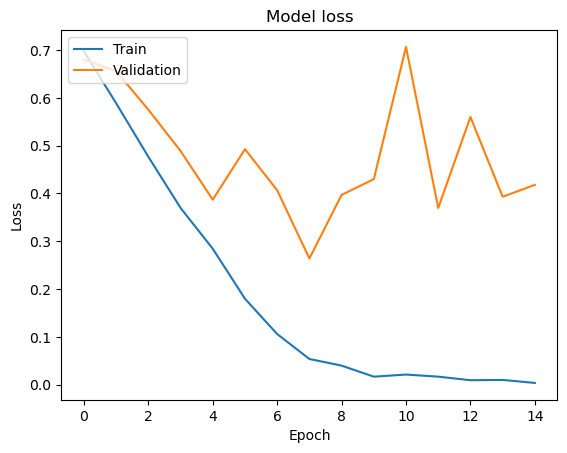

In [133]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

#### Epoch = 10, Batch Size = 16

In [123]:
model_optim = get_model()
# model_optim.summary()

early_stopping_monitor_optim = EarlyStopping(patience=10)
history_optim = model_optim.fit([processed_x_train,processed_pre_x_train], 
                                y_train, 
                                validation_data=([processed_x_test,processed_pre_x_test],y_test), 
                                epochs=10, batch_size=16, callbacks=[early_stopping_monitor_optim], verbose=1)
loss_optim, accuracy_optim, f1_score_optim, precision_optim, recall_optim = model_optim.evaluate([processed_x_test, processed_pre_x_test], y_test)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 embedding_28 (Embedding)    (None, 415, 100)             963600    ['input_31[0][0]']            
                                                                                                  
 embedding_29 (Embedding)    (None, 415, 100)             963600    ['input_32[0][0]']            
                                                                                           

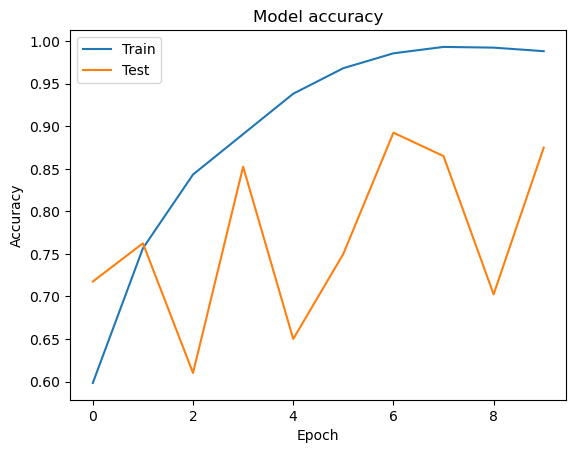

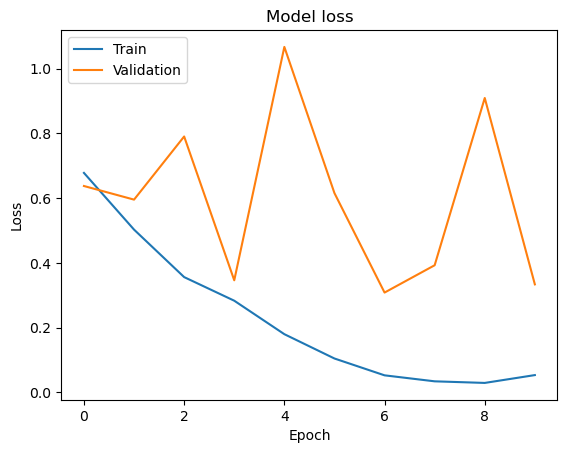

In [132]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_optim.history['accuracy'])
plt.plot(history_optim.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

# Plot training & validation loss values
plt.plot(history_optim.history['loss'])
plt.plot(history_optim.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

#### Epoch = 15, Batch Size = 64

In [137]:
model_optim_2 = get_model()
# model_optim_2.summary()

early_stopping_monitor_optim_2 = EarlyStopping(patience=10)
history_optim_2 = model_optim_2.fit([processed_x_train,processed_pre_x_train], 
                                y_train, 
                                validation_data=([processed_x_test,processed_pre_x_test],y_test), 
                                epochs=15, batch_size=64, callbacks=[early_stopping_monitor_optim_2], verbose=1)
loss_optim_2, accuracy_optim_2, f1_score_optim_2, precision_optim_2, recall_optim_2 = model_optim_2.evaluate([processed_x_test, processed_pre_x_test], y_test)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 input_38 (InputLayer)       [(None, 415)]                0         []                            
                                                                                                  
 embedding_34 (Embedding)    (None, 415, 100)             963600    ['input_37[0][0]']            
                                                                                                  
 embedding_35 (Embedding)    (None, 415, 100)             963600    ['input_38[0][0]']            
                                                                                           

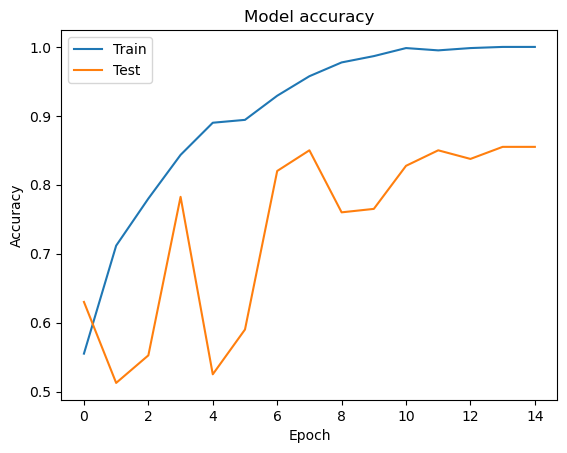

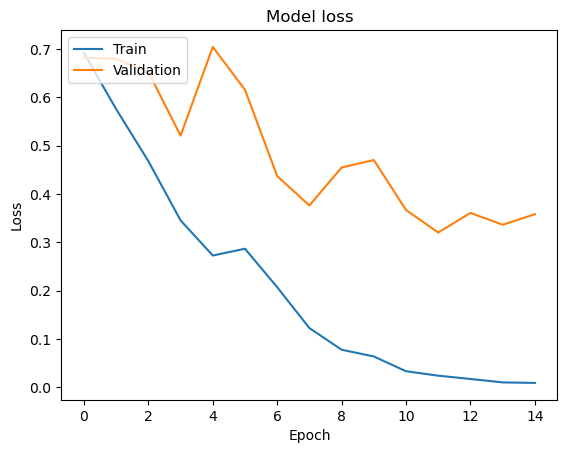

In [138]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_optim_2.history['accuracy'])
plt.plot(history_optim_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

# Plot training & validation loss values
plt.plot(history_optim_2.history['loss'])
plt.plot(history_optim_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

#### Epoch = 10, Batch Size = 32

In [140]:
model_optim_3 = get_model()
# model_optim_3.summary()

early_stopping_monitor_optim_3 = EarlyStopping(patience=10)
history_optim_3 = model_optim_3.fit([processed_x_train,processed_pre_x_train], 
                                y_train, 
                                validation_data=([processed_x_test,processed_pre_x_test],y_test), 
                                epochs=10, batch_size=32, callbacks=[early_stopping_monitor_optim_3], verbose=1)
loss_optim_3, accuracy_optim_3, f1_score_optim_3, precision_optim_3, recall_optim_3 = model_optim_3.evaluate([processed_x_test, processed_pre_x_test], y_test)

Epoch 1/10
38/38 [==============================] - 41s 806ms/step - loss: 0.6698 - accuracy: 0.6133 - f1_m: 0.6062 - precision_m: 0.6207 - recall_m: 0.6088 - val_loss: 0.6673 - val_accuracy: 0.6750 - val_f1_m: 0.7333 - val_precision_m: 0.6164 - val_recall_m: 0.9192
Epoch 2/10
38/38 [==============================] - 30s 781ms/step - loss: 0.5272 - accuracy: 0.7375 - f1_m: 0.7320 - precision_m: 0.7527 - recall_m: 0.7302 - val_loss: 0.6244 - val_accuracy: 0.5925 - val_f1_m: 0.3017 - val_precision_m: 0.9231 - val_recall_m: 0.1868
Epoch 3/10
38/38 [==============================] - 32s 840ms/step - loss: 0.3747 - accuracy: 0.8433 - f1_m: 0.8455 - precision_m: 0.8377 - recall_m: 0.8667 - val_loss: 0.5540 - val_accuracy: 0.7950 - val_f1_m: 0.7510 - val_precision_m: 0.9494 - val_recall_m: 0.6253
Epoch 4/10
38/38 [==============================] - 32s 842ms/step - loss: 0.2692 - accuracy: 0.8917 - f1_m: 0.8903 - precision_m: 0.8823 - recall_m: 0.9076 - val_loss: 0.6200 - val_accuracy: 0.6600 

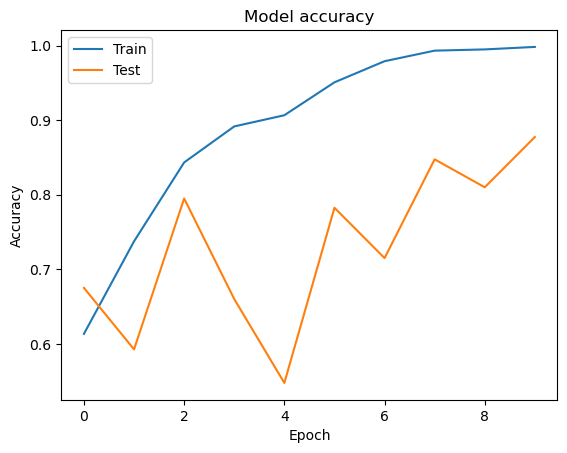

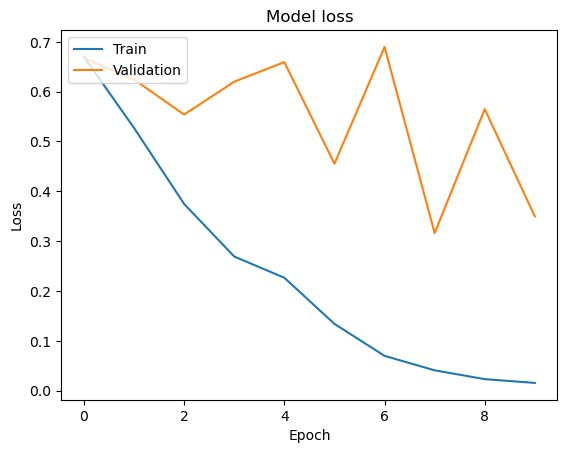

In [141]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_optim_3.history['accuracy'])
plt.plot(history_optim_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

# Plot training & validation loss values
plt.plot(history_optim_3.history['loss'])
plt.plot(history_optim_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

## Result

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
lr_accuracy = accuracy_score(lrpredicted, y_test)
print("=================Logistic Regression Test Result==================")
print('Accuracy score:  ', f'{format(round(100*accuracy_score(lrpredicted, y_test), 2))}%')
print('Precision score: ', f'{format(round(100*precision_score(y_test, lrpredicted), 2))}%')
print('Recall score:    ', f'{format(round(100*recall_score(y_test, lrpredicted), 2))}%')
print('F1 score:        ', f'{format(round(100*f1_score(y_test, lrpredicted)))}%')

print("==========Attention-based bidirectional LSTM Test Result==========")
print('Accuracy score:  ', f'{round(100*accuracy, 2)}%')
print('Precision score: ', f'{round(100*precision, 2)}%')
print('Recall score:    ', f'{round(100*recall, 2)}%')
print('F1 score:        ', f'{round(100*F1_score, 2)}%')


=================Logistic Regression Test Result==================
Accuracy score:   85.0%
Precision score:  84.31%
Recall score:     86.0%
F1 score:         85%
==========Attention-based bidirectional LSTM Test Result==========
Accuracy score:   86.25%
Precision score:  88.36%
Recall score:     84.85%
F1 score:         86.36%


In [124]:
lr_accuracy = accuracy_score(lrpredicted, y_test)
print("=================Logistic Regression Test Result==================")
print('Accuracy score:  ', f'{format(round(100*accuracy_score(lrpredicted, y_test), 2))}%')
print('Precision score: ', f'{format(round(100*precision_score(y_test, lrpredicted), 2))}%')
print('Recall score:    ', f'{format(round(100*recall_score(y_test, lrpredicted), 2))}%')
print('F1 score:        ', f'{format(round(100*f1_score(y_test, lrpredicted)))}%')

print("==========Attention-based bidirectional LSTM Test Result==========")
print('Accuracy score:  ', f'{round(100*accuracy_optim, 2)}%')
print('Precision score: ', f'{round(100*precision_optim, 2)}%')
print('Recall score:    ', f'{round(100*recall_optim, 2)}%')
print('F1 score:        ', f'{round(100*f1_score_optim, 2)}%')


=================Logistic Regression Test Result==================
Accuracy score:   85.0%
Precision score:  84.31%
Recall score:     86.0%
F1 score:         85%
==========Attention-based bidirectional LSTM Test Result==========
Accuracy score:   87.5%
Precision score:  89.33%
Recall score:     85.66%
F1 score:         87.29%


In [142]:
lr_accuracy = accuracy_score(lrpredicted, y_test)
print("=================Logistic Regression Test Result==================")
print('Accuracy score:  ', f'{format(round(100*accuracy_score(lrpredicted, y_test), 2))}%')
print('Precision score: ', f'{format(round(100*precision_score(y_test, lrpredicted), 2))}%')
print('Recall score:    ', f'{format(round(100*recall_score(y_test, lrpredicted), 2))}%')
print('F1 score:        ', f'{format(round(100*f1_score(y_test, lrpredicted)))}%')

print("==========Attention-based bidirectional LSTM Test Result==========")
print('Accuracy score:  ', f'{round(100*accuracy_optim_3, 2)}%')
print('Precision score: ', f'{round(100*precision_optim_3, 2)}%')
print('Recall score:    ', f'{round(100*recall_optim_3, 2)}%')
print('F1 score:        ', f'{round(100*f1_score_optim_3, 2)}%')


=================Logistic Regression Test Result==================
Accuracy score:   85.0%
Precision score:  84.31%
Recall score:     86.0%
F1 score:         85%
==========Attention-based bidirectional LSTM Test Result==========
Accuracy score:   87.75%
Precision score:  84.49%
Recall score:     93.0%
F1 score:         88.29%
